In [1]:
# import needed libs
import cv2
import math
import numpy as np
import os
import mediapipe as mp
import pickle
import collections

In [2]:
# dirs
# specify main dir
main_dir = '../'
src_dir = main_dir + "src/"

vid_dir = src_dir + "vid/"
vid_vid_dir = vid_dir + "vid/"
vid_pic_dir = vid_dir + "pic/"

type_dir = src_dir + "hand/"

det_dir = type_dir + "det/"
rend_dir = type_dir + "rend/"
rend_vid_dir = rend_dir + "vid/"
rend_pic_dir = rend_dir + "pic/"

In [3]:
# CONFIG
VID_SUF = ".mp4"
S = "/"

# relinquit
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# common frame size in the videos
FRAME_WIDTH = 1280
FRAME_HEIGHT = 720

In [4]:
# prepare mp
mp_hands = mp.solutions.hands
# Import drawing_utils and drawing_styles.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [5]:
class AnyIO: 
    # This class is a wrapper to read and write pickle files
    @staticmethod
    def read(IOPath): 
        # only used by loss hists 
        with open(IOPath, 'rb') as f:
            return pickle.load(f)
    @staticmethod
    def save(IOPath, content): 
        with open(IOPath, 'wb') as file:
            pickle.dump(content, file)

class ResultIO: 
    # This class is a wrapper to read and write SolutionOutput objects
    @staticmethod
    def read(IOPath): 
        # only used by loss hists 
        with open(IOPath, 'rb') as f:
            clean_res = pickle.load(f)
        res = collections.namedtuple(
            'SolutionOutputs', clean_res.keys())
        for field in clean_res.keys(): 
            setattr(res, field, clean_res[field])
        return res

    @staticmethod
    def save(IOPath, result): 
        fields = result._fields
        clean_res = {}
        for field in fields: 
            clean_res[field] = getattr(result, field)
        
        with open(IOPath, 'wb') as file:
            pickle.dump(clean_res, file)

In [6]:
class DetectionWrapper: 
    def __init__(self, ptcp_file, filename): 
        self.name = filename

        self.vidpath = vid_vid_dir + ptcp_file + S + filename + VID_SUF
        self.dd = det_dir + ptcp_file + S + filename + S
        self.rpd = rend_pic_dir + ptcp_file + S + filename + S
        self.rvd = rend_vid_dir + ptcp_file + S

        # create specific det and rend dir (det dir is for detection result source file, rend dir is for rendered pics and vids)
        if not os.path.exists(self.dd): 
            os.makedirs(self.dd)
        if not os.path.exists(self.rpd): 
            os.makedirs(self.rpd)
        if not os.path.exists(self.rvd): 
            os.makedirs(self.rvd)

        self.images = []
        # self.annotated_images = []
        self.fps = 0    # to be obtained for video saving
        self.framesize = (FRAME_WIDTH, FRAME_HEIGHT)

        # Find OpenCV version
        (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
        if int(major_ver) < 3:
            self.FPS_TYPE = cv2.cv.CV_CAP_PROP_FPS
        else:
            self.FPS_TYPE = cv2.CAP_PROP_FPS
        
    def getImgs(self): 
        # Path to video file
        vidObj = cv2.VideoCapture(self.vidpath)
        self.fps = vidObj.get(self.FPS_TYPE)

        # Used as counter variable
        count = 0  
        # checks whether frames were extracted
        success = 1
    
        while success:
            # vidObj object calls read
            # function extract frames
            success, image = vidObj.read()
            # Saves the frames with frame-count
            if success: 
                self.images.append(image)
                count += 1
    
    def resize(self): 
        # relinquit
        for image in self.images:
            h, w = image.shape[:2]
            if h < w:
                img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
            else:
                img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    
    def detect(self): 
        outvid = cv2.VideoWriter("{}{}.mp4".format(self.rvd, self.name),cv2.VideoWriter_fourcc(*'mp4v'), self.fps, self.framesize)
        print("Video name {}".format(self.name))
        with mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=2,
            min_detection_confidence=0.5) as hands:
            for idx, image in enumerate(self.images):
                # Convert the BGR image to RGB, flip the image around y-axis for correct 
                # handedness output and process it with MediaPipe Hands.
                results = hands.process(cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1))

                ResultIO.save("{}{}_{:0>6}.pkl".format(self.dd, self.name, idx), results)

                # Draw pose landmarks and save to pic.
                annotated_image = cv2.flip(image.copy(), 1)
                if results.multi_hand_landmarks: 
                    for hand_landmarks in results.multi_hand_landmarks:
                        # Print index finger tip coordinates.
                        mp_drawing.draw_landmarks(
                            annotated_image,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())
                # write image to image save dir
                cv2.imwrite("{}{}_{:0>6}.jpg".format(self.rpd, self.name, idx), cv2.flip(annotated_image, 1))
                # self.annotated_images.append(annotated_image)
                outvid.write(cv2.flip(annotated_image, 1))
        outvid.release()

In [13]:
# for vd in os.listdir(vid_vid_dir): "KorS-AQ4_Resultant"
for vd in ["JapS-AQ4_Resultant"]: 
    for v in os.listdir(vid_vid_dir + vd + "/"): 
        if v.endswith(VID_SUF): 
            # this means it is a video
            filename = v.split(".")[0]
            dw = DetectionWrapper(vd, filename)
            dw.getImgs()
            dw.detect()

Video name JapS-AQ4_bon
Video name JapS-AQ4_booboo
Video name JapS-AQ4_chokichoki
Video name JapS-AQ4_gorogoro
Video name JapS-AQ4_kachikachi
Video name JapS-AQ4_kirakira
Video name JapS-AQ4_kyutto
Video name JapS-AQ4_nebaneba
Video name JapS-AQ4_panpan
Video name JapS-AQ4_perapera
Video name JapS-AQ4_pikapika
Video name JapS-AQ4_pon
Video name JapS-AQ4_tonton
Video name JapS-AQ4_tsuntsun
Video name JapS-AQ4_yurayura
Video name JapS-AQ4_zuratto


# This is successful! 

In [78]:
from google.protobuf.json_format import MessageToDict
import json

In [79]:
def mk(dir): 
    os.makedirs(dir, exist_ok = True)

In [80]:
def lm_has_side_and_is_at(lm, side): 
    # side: 0 == left, 1 == right
    if lm.multi_handedness is None: 
        return False, 0
    elif len(lm.multi_handedness) == 1: 
        handedness_dict = MessageToDict(lm.multi_handedness[0])
        return handedness_dict["classification"][0]["index"] == side, 0
    elif len(lm.multi_handedness) == 2:
        return True, side
    else: 
        return False, 0

In [81]:
graph_dir = type_dir + "graph/"

In [82]:
el = list(mp_hands.HAND_CONNECTIONS)
el = [list(element) for element in el]

In [83]:
def sol2json(d, json_path): 
    with open(json_path, 'w') as fl:
        has, at = lm_has_side_and_is_at(d, 0)
        if has: 
            ml = (MessageToDict(d.multi_hand_landmarks[at])["landmark"]) # 0 is one of the hands, do this first
            my_dict = {str(i): (d['x'], d['y'], d['z']) for i, d in enumerate(ml)}
        else: 
            my_dict = {str(i): (0, 0, 0) for i in range(21)} # default (0, 0, 0) for all nodes
        outdict = {"edges": el, "features": my_dict}
        fl.write(json.dumps(outdict, separators=(',', ':')))

In [87]:
mk(graph_dir)

In [88]:
for vd in ["JapS-AQ4_Resultant"]: 
    for clip in os.listdir(det_dir + vd + "/"): 
        vid_graph_dir = graph_dir + vd + "/" + clip + "/"
        # mk(vid_graph_dir)
        print(clip)
        for g in os.listdir(det_dir + vd + "/" + clip + "/"): 
            clip_dir = det_dir + vd + "/" + clip + "/"
            if g.endswith(".pkl"): 
                name, ext = g.split(".")
                d = ResultIO.read(os.path.join(clip_dir, g))
                json_path = os.path.join(graph_dir, "{}.json".format(name))
                sol2json(d, json_path)

JapS-AQ4_bon
JapS-AQ4_booboo
JapS-AQ4_chokichoki
JapS-AQ4_gorogoro
JapS-AQ4_kachikachi
JapS-AQ4_kirakira
JapS-AQ4_kyutto
JapS-AQ4_nebaneba
JapS-AQ4_panpan
JapS-AQ4_perapera
JapS-AQ4_pikapika
JapS-AQ4_pon
JapS-AQ4_tonton
JapS-AQ4_tsuntsun
JapS-AQ4_yurayura
JapS-AQ4_zuratto


# Plot extracted vecs

In [138]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [139]:
def read_vid_graph(name, src): 
    # Read the CSV file into a DataFrame
    df = pd.read_csv(src)

    df = df[df['type'].str.startswith(name)]

    # Get the list of names
    names = df['type'].tolist()

    # Get the data columns and convert them to NumPy arrays
    data = df.loc[:, 'x_0':].to_numpy()

    # Stack the arrays into a matrix
    matrix = np.vstack(data)
    return names, matrix

In [140]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [149]:
n, m = read_vid_graph("", "lefthd.csv")

In [150]:
m.shape

(1580, 32)

In [151]:
d = m[:, :]

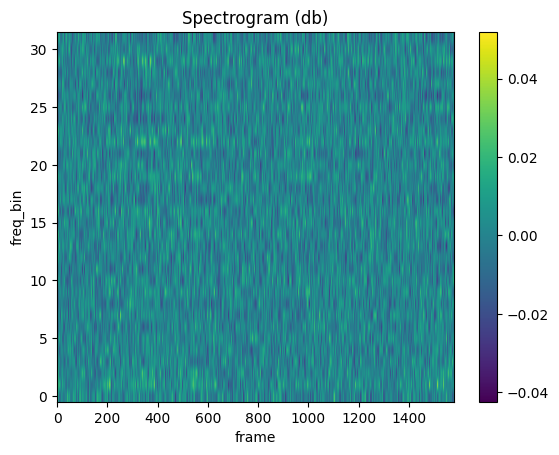

In [152]:
plot_spectrogram(d.T)

In [153]:
n, m = read_vid_graph("JapS-AQ4_bon_", "lefthd.csv")

In [154]:
n

['JapS-AQ4_bon_000000',
 'JapS-AQ4_bon_000001',
 'JapS-AQ4_bon_000002',
 'JapS-AQ4_bon_000003',
 'JapS-AQ4_bon_000004',
 'JapS-AQ4_bon_000005',
 'JapS-AQ4_bon_000006',
 'JapS-AQ4_bon_000007',
 'JapS-AQ4_bon_000008',
 'JapS-AQ4_bon_000009',
 'JapS-AQ4_bon_000010',
 'JapS-AQ4_bon_000011',
 'JapS-AQ4_bon_000012',
 'JapS-AQ4_bon_000013',
 'JapS-AQ4_bon_000014',
 'JapS-AQ4_bon_000015',
 'JapS-AQ4_bon_000016',
 'JapS-AQ4_bon_000017',
 'JapS-AQ4_bon_000018',
 'JapS-AQ4_bon_000019',
 'JapS-AQ4_bon_000020',
 'JapS-AQ4_bon_000021',
 'JapS-AQ4_bon_000022',
 'JapS-AQ4_bon_000023',
 'JapS-AQ4_bon_000024',
 'JapS-AQ4_bon_000025',
 'JapS-AQ4_bon_000026',
 'JapS-AQ4_bon_000027',
 'JapS-AQ4_bon_000028',
 'JapS-AQ4_bon_000029',
 'JapS-AQ4_bon_000030',
 'JapS-AQ4_bon_000031',
 'JapS-AQ4_bon_000032',
 'JapS-AQ4_bon_000033',
 'JapS-AQ4_bon_000034',
 'JapS-AQ4_bon_000035',
 'JapS-AQ4_bon_000036',
 'JapS-AQ4_bon_000037',
 'JapS-AQ4_bon_000038',
 'JapS-AQ4_bon_000039',
 'JapS-AQ4_bon_000040',
 'JapS-AQ4_bon_0

In [160]:
import scipy.spatial.distance as dist

In [155]:
select = m[[18, 28, 42], :]

In [157]:
a, b, c = select[0, :], select[1, :], select[2, :]

In [164]:
dist.euclidean(a, b)

0.16902517124143357

In [165]:
dist.euclidean(a, c)

0.1609452367900345

In [166]:
dist.euclidean(b, c)

0.12647192310423347